## Stimuli for Psychophysics Experiments based on wavelet representation

In [49]:
import pywt
import matplotlib.pyplot as plt
import numpy as np

#jupyter notebook settings
%matplotlib inline
%config InlineBackend.print_figure_kwargs = {'dpi' : 200} #plotting pretty

In [102]:
pywt.families()

['haar',
 'db',
 'sym',
 'coif',
 'bior',
 'rbio',
 'dmey',
 'gaus',
 'mexh',
 'morl',
 'cgau',
 'shan',
 'fbsp',
 'cmor']

Text(0.5,1,'Step Function')

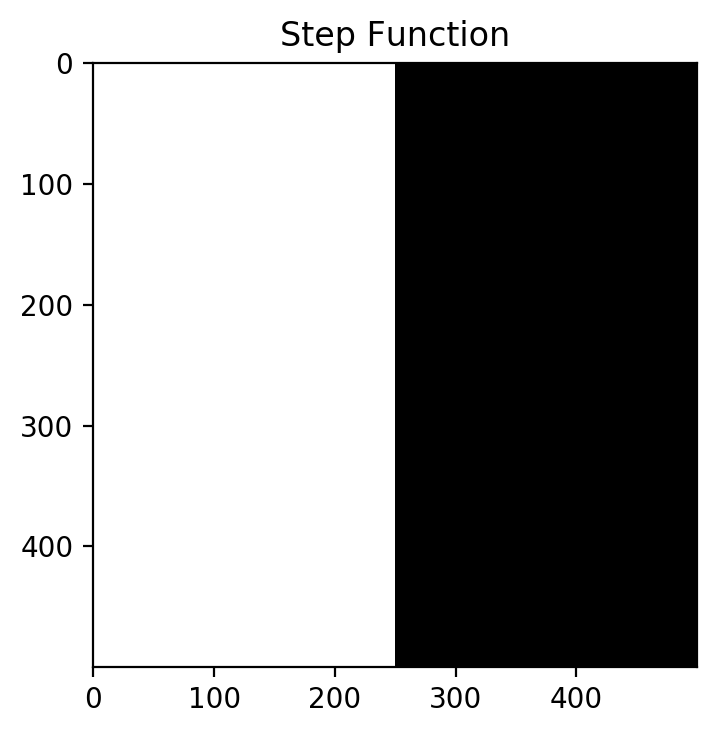

In [79]:
#make step function 
stim_width = 500
stim_height = 500
step_fun = np.hstack((np.ones((stim_height, stim_width//2)),
                     np.zeros((stim_height, stim_width//2)))
                    )
plt.imshow(step_fun,cmap='Greys_r')
plt.title('Step Function')

In [46]:
# Copyright (c) 2006-2012 Filip Wasilewski <http://en.ig.ma/>
# Copyright (c) 2012-2016 The PyWavelets Developers
#                         <https://github.com/PyWavelets/pywt>
# See COPYING for license details.

"""
Wavelet Image Blender.
Blend image A with texture extracted from image B by selecting
detail coefficients:
    -----------------     -----------------
    |               |     |               |
    |               |     |               |
    |               |     |               |
    |       A       |     |       B       |
    |               |     |               |
    |               |     |               |
    |               |     |               |
    -----------------     -----------------
            |                     |
     2D DWT |              2D DWT |
            V                     V
    -----------------             ---------          -----------------
    |       |       |             |       |          |               |
    | A(LL) | H(LH) |             | H(LH) |          |               |
    |       |       |             |       |   IDWT   |               |
    -----------------  +  -----------------  ----->  |       C       |
    |       |       |     |       |       |          |               |
    | V(HL) | D(HH) |     | V(HL) | D(HH) |          |               |
    |       |       |     |       |       |          |               |
    -----------------     -----------------          -----------------
                            (details only)
"""

import optparse
import os
import sys
if os.name == 'nt':
    from time import clock  # noqa
else:
    from time import time as clock  # noqa

from PIL import Image  # PIL
import numpy  # http://www.scipy.org

import pywt


def image2array(image):
    """PIL Image to NumPy array"""
    assert image.mode in ('L', 'RGB', 'CMYK')
    arr = numpy.fromstring(image.tobytes(), numpy.uint8)
    arr.shape = (image.size[1], image.size[0], len(image.getbands()))
    return arr.swapaxes(0, 2).swapaxes(1, 2).astype(numpy.float32)


def array2image(arr, mode):
    """NumPy array to PIL Image"""
    arr = arr.swapaxes(1, 2).swapaxes(0, 2)
    arr[arr < 0] = 0
    arr[arr > 255] = 255
    arr = numpy.fix(arr).astype(numpy.uint8)
    return Image.frombytes(mode, arr.shape[1::-1], arr.tobytes())


def load_image(path, mode=None, size=None):
    """Load image"""
    im = Image.open(path)

    if im.mode not in ('L', 'P', 'RGB', 'CMYK'):
        raise TypeError("Image mode must be 'L', 'P', 'RGB' or 'CMYK'")

    if mode is not None:
        if mode == 'P':
            raise ValueError("Mode must be 'L', 'RGB' or 'CMYK'")
        im = im.convert(mode)
    elif im.mode == 'P':
        im = im.convert('RGB')

    if size is not None and im.size != size:
        im = im.resize(size, Image.ANTIALIAS)
    return im


def blend_images(base, texture, wavelet, level, mode='smooth', base_gain=None,
                 texture_gain=None):
    """Blend loaded images at `level` of granularity using `wavelet`"""

    base_data = image2array(base)
    texture_data = image2array(texture)
    output_data = []

    # process color bands
    for base_band, texture_band in zip(base_data, texture_data):
        # multilevel dwt
        base_band_coeffs = pywt.wavedec2(base_band, wavelet, mode, level)
        texture_band_coeffs = pywt.wavedec2(texture_band, wavelet, mode, level)

        # average coefficients of base image
        output_band_coeffs = [base_band_coeffs[0]]  # cA
        del base_band_coeffs[0], texture_band_coeffs[0]

        # blend details coefficients
        for n, (base_band_details, texture_band_details) in enumerate(
                zip(base_band_coeffs, texture_band_coeffs)):
            blended_details = []
            for (base_detail, texture_detail) in zip(base_band_details,
                                                     texture_band_details):
                if base_gain is not None:
                    base_detail *= base_gain
                if texture_gain is not None:
                    texture_detail *= texture_gain

                # select coeffs with greater energy
                blended = numpy.where(abs(base_detail) > abs(texture_detail),
                                      base_detail, texture_detail)
                blended_details.append(blended)

            base_band_coeffs[n] = texture_band_coeffs[n] = None
            output_band_coeffs.append(blended_details)

        # multilevel idwt
        new_band = pywt.waverec2(output_band_coeffs, wavelet, mode)
        output_data.append(new_band)
        del new_band, base_band_coeffs, texture_band_coeffs

    del base_data, texture_data
    output_data = numpy.array(output_data)

    return array2image(output_data, base.mode)


# def main():
#     usage = "usage: %prog -b BASE -t TEXTURE -o OUTPUT "\
#             "[-w WAVELET] [-l LEVEL] [-m MODE]"
#     parser = optparse.OptionParser(usage=usage)
#     parser.add_option("-b", "--base", dest="base", metavar="BASE",
#                       help="base image name")
#     parser.add_option("-t", "--texture", dest="texture", metavar="TEXTURE",
#                       help="texture image name")
#     parser.add_option("-o", "--output", dest="output", metavar="OUTPUT",
#                       help="output image name")
#     parser.add_option("-w", "--wavelet", dest="wavelet", metavar="WAVELET",
#                       default='db2', help="wavelet name [default: %default]")
#     parser.add_option("-l", "--level", dest="level", metavar="LEVEL",
#                       type="int", default=4,
#                       help="decomposition level [default: %default]")
#     parser.add_option("-m", "--mode", dest="mode", metavar="MODE",
#                       default='symmetric',
#                       help="decomposition mode. Adjust this if"
#                       " getting edge artifacts [default: %default]")
#     parser.add_option("-x", "--base_gain", dest="base_gain", metavar="BG",
#                       type="float", default=None,
#                       help="Base image gain [default: %default]")
#     parser.add_option("-y", "--texture_gain", dest="texture_gain",
#                       metavar="TG", type="float", default=None,
#                       help="Texture image gain [default: %default]")
#     parser.add_option("--timeit", dest="timeit", action="store_true",
#                       default=False, help="time blending operations")

#     (options, args) = parser.parse_args()

#     if None in (options.base, options.texture, options.output):
#         parser.print_help()
#         sys.exit(-1)

#     base = load_image(options.base)
#     texture = load_image(options.texture, base.mode, base.size)

#     if options.timeit:
#         t = clock()

#     im = blend_images(base, texture, options.wavelet, options.level,
#                       options.mode, options.base_gain, options.texture_gain)

#     if options.timeit:
#         print("%.3fs" % (clock() - t))

#     im.save(options.output)

# if __name__ == '__main__':
#     main()



/home/vasha/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:51: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


(-0.5, 825.5, 619.5, -0.5)

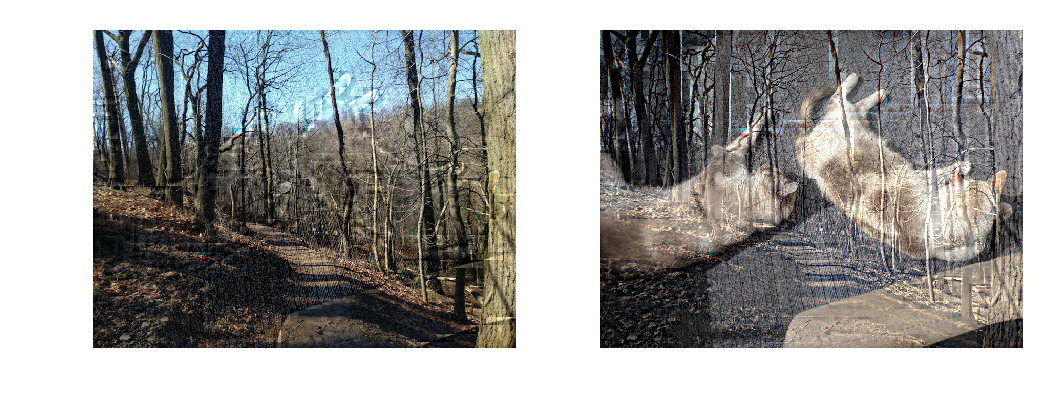

In [52]:
trail = load_image('./ims/trail.jpg')
cats = load_image('./ims/cats.jpg')
base = trail
texture = cats

im1 = blend_images(base, texture, 'haar', 4)
im2 = blend_images(texture, base, 'haar', 4)

plt.subplot(121)
plt.imshow(im1);
plt.axis('off')
plt.subplot(122)
plt.imshow(im2);
plt.axis('off')

Text(0.5,1,'recon')

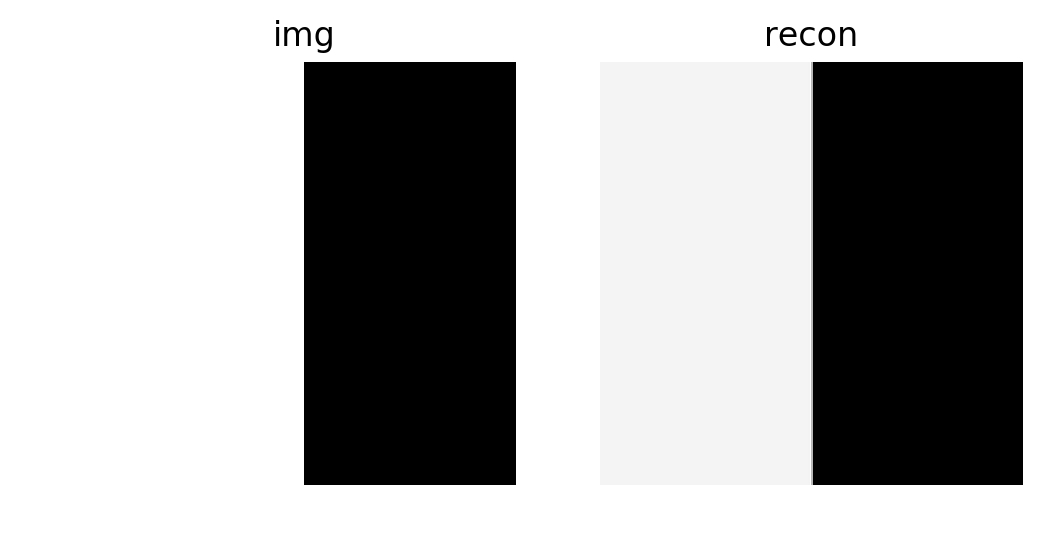

In [124]:
trail_bw = np.mean(trail,axis=2)
cats_bw = np.mean(cats,axis=2)

im = step_fun
wavelet = 'db4'
mode = 'smooth'
level = 6
missing_levels = 1

# multilevel dwt
im_band_coeffs = pywt.wavedec2(im, wavelet, mode, level)
len(im_band_coeffs)

recon = pywt.waverec2(im_band_coeffs[:-missing_levels], wavelet, mode)

plt.subplot(121)
plt.imshow(im,cmap='Greys_r');
plt.axis('off')
plt.title('img')
plt.subplot(122)
plt.imshow(recon, cmap='Greys_r');
plt.axis('off')
plt.title('recon')


## TODO:

Understanding 
* Understand better where high and low fq wavelets are stored in the datastructure.
* Need mapping from wavelet size to pixels (eventually to CPD)  
* Fourier Version of all this

Program Hygene
* Put this code in util files that are easily callable
* write these images to file in batch (choosing appropriate cuttoff values)
